In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import get_csv_row_count
from models.utils import get_folder_path
from models.utils import fit_circle
from models.utils import plot_column_histograms
import time
import csv

import scipy.stats as sc

In [39]:
##FINAL VERSION WITH FITNESS FUNCTION NOT COMPUTED EVRY TIME

np.random.seed(2)

class Particle:
    def __init__(self, position, velocity,id, dimension, ref_traj):
        # Necessary for all the particles iincluding thrash one
        self.dt = 0.025
        self.commands = get_folder_path()+'/open_loop_inputs/open_loop_commands.csv'
        self.N = get_csv_row_count(self.commands)
        self.open_loop_tf = self.N*self.dt

        self.position = position
        self.velocity = velocity
        self.best_position = position.copy()
        self.dimension = dimension

        #related to vehicle model
        self.param_to_infer = 2

        self.x_vect_ref = ref_traj
        
        #print(self.x_vect_ref.shape)
        #print(self.x_vect_ref)
        self.model = None
        # T_peak and T_slope is not specified since we infer those
        self.id = id
        dim = int(self.x_vect_ref.shape[1]/6)
        #print(dim)

        
        self.position_cost_value = self.compute_fitness_function()
        self.best_position_cost_value = float(self.position_cost_value)


    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        
        self.position += self.velocity
        self.position = np.clip(self.position, lower_bounds, upper_bounds)
        self.position_cost_value = self.compute_fitness_function()

    def update_best_position(self):
        if self.position_cost_value < self.best_position_cost_value:
            self.best_position = self.position.copy()
            self.best_position_cost_value = self.position_cost_value
    
    def compute_fitness_function(self):
        return self.get_kpi()
    
    def get_kpi(self):
        self.generate_new_model(self.position[:self.param_to_infer])
        t,x_vect = self.get_open_loop_data()
        
        l2_norm_position = np.linalg.norm(self.x_vect_ref[:,:2] - x_vect[:,:2], axis=1).sum()
        l2_norm_velocity = np.linalg.norm(self.x_vect_ref[:,2:] - x_vect[:,2:], axis=1).sum()

        w1 = 0.5
        w2 = 0.5
        kpi = w1*l2_norm_position+w2*l2_norm_velocity
        return kpi
        
    
    def get_open_loop_data(self):
        
        t,x_vect = self.model.do_open_loop_sim_from_csv(self.commands)
                
        return t,x_vect
    
    def generate_new_model(self, particle):
        T_peak = particle[0]
        T_slope = particle[1]
        self.model = FourWheelModel( self.dt, self.open_loop_tf,float(T_peak), float(T_slope))

class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds, dimension, ref_traj):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.dimension = dimension
        self.particles = []
        self.global_best_position = None
        self.global_best_position_cost = None
        
        self.ref_traj = ref_traj


        self.particle_positions_history = []
        self.particle_fitness_history = []




    #------------------OPTIMIZATION------------------#

    def optimize(self, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for iter in range(self.max_iterations):
            
            self.particle_positions_history.append([ particle.position for particle in self.particles])
            self.particle_fitness_history.append([particle.position_cost_value for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position()

            self.update_global_best_position()
            if iter%10 == 0:
                print('Iteration: ', iter)

    def initialize_particles(self):
        self.particles = []
        
        t_before =  time.time()
        # Thrash particle to get the right value of x_ref
        for i in range(self.num_particles):
            position = np.random.uniform(self.lower_bounds, self.upper_bounds, size=self.dimension)
            velocity = np.zeros_like(position)
            id = i
            dimension = self.dimension
            particle = Particle(position, velocity, id, dimension, self.ref_traj)
            self.particles.append(particle)
        t_after = time.time()
        elapsed_time = t_after-t_before
        print('All particles are initialized in: ', elapsed_time, ' Expected time for inference: ', elapsed_time*self.max_iterations)
        

        index_best_initial_particle = np.argmin([ particle.position_cost_value for particle in self.particles])
        self.global_best_position = self.particles[index_best_initial_particle].position.copy()
        self.global_best_position_cost = self.particles[index_best_initial_particle].position_cost_value

    def update_global_best_position(self):
        for particle in self.particles:
            if particle.position_cost_value < self.global_best_position_cost:
                self.global_best_position = particle.position.copy()
                self.global_best_position_cost = particle.position_cost_value


    def plot_particle_positions(self, frame):
        plt.cla()
        positions = np.array(self.particle_positions_history[frame])
        for i in range(self.dimension):
            plt.plot(positions[:, i], np.zeros_like(positions[:, i]), 'go', markersize=6)
        plt.xlabel('x')
        plt.ylim([-0.5, 0.5])

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel('Fitness')
        ax1.set_ylabel('Count')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel('Fitness')
        ax2.set_ylabel('Count')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel('Fitness')
        ax3.set_ylabel('Count')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()


    def plot_particle_history(self):
        if self.dimension == 1:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

            # Plot histogram at the start
            ax1.hist(self.particle_positions_history[0], bins=20, color='blue', edgecolor='black')
            ax1.set_xlabel('')
            ax1.set_ylabel('Count')
            ax1.set_title('Start of Optimization')

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist(self.particle_positions_history[middle_index], bins=20, color='green', edgecolor='black')
            ax2.set_xlabel('x')
            ax2.set_ylabel('Count')
            ax2.set_title('Middle of Optimization')

            # Plot histogram at the end
            ax3.hist(self.particle_positions_history[-1], bins=20, color='red', edgecolor='black')
            ax3.set_xlabel('x')
            ax3.set_ylabel('Count')
            ax3.set_title('End of Optimization')

            plt.tight_layout()
            plt.show()


        if self.dimension == 2:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
            # Plot histogram at the start
            ax1.hist2d(self.particle_positions_history[0][:, 0], self.particle_positions_history[0][:, 1], bins=20, cmap='viridis')
            ax1.set_xlabel(r'$T_{peak}$')
            ax1.set_ylabel(r'$T_{front}$')
            ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist2d(self.particle_positions_history[middle_index][:, 0],self.particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
            ax2.set_xlabel(r'$T_{peak}$')
            ax2.set_ylabel(r'$T_{front}$')
            ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))

            # Plot histogram at the end
            ax3.hist2d(self.particle_positions_history[-1][:, 0], self.particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
            ax3.set_xlabel(r'$T_{peak}$')
            ax3.set_ylabel(r'$T_{front}$')
            ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))

            plt.tight_layout()
            plt.show()

    def plot_particle_positions_animate(self):
        self.X, self.Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
        self.Z = self.X**2 + self.Y**2

        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()

    def save_to_csv(self, path):
        iteration = self.max_iterations
        num_particles = self.num_particles
        particles_positions = self.particle_positions_history.reshape(-1,2)

        # Define the CSV file path
        csv_file = path

        # Write data to CSV file
        with open(csv_file, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['T_peak', 'T_front', 'Iteration', 'Particles'])
            writer.writerow([particles_positions[0, 0], particles_positions[0, 1], iteration, num_particles])
            writer.writerows(particles_positions[1:])

        print(f"Data saved to {csv_file}.")


# Example usage
upper_bouds_1d = 10
lower_bouds_1d = -10
upper_bouds_2d = [1,1]
lower_bouds_2d = [0.,0.]
#pso = PSO(num_particles=10, max_iterations=30, lower_bounds=lower_bouds_2d, upper_bounds=upper_bouds_2d, dimension=2)


'''pso.optimize()
pso.plot_particle_history()
pso.plot_particle_fitness_history()'''
#pso.save_to_csv('./Results/PSO/iter50particle10.csv')



'pso.optimize()\npso.plot_particle_history()\npso.plot_particle_fitness_history()'

In [40]:
x_vect_ref = np.genfromtxt('Data/Data_four_wheel/trajectories.csv', delimiter=',')

x_vect_ref = x_vect_ref

history_list = []
print(int(x_vect_ref.shape[1])/6)
for i in range(0,int(x_vect_ref.shape[1]),6):
    x_ref = x_vect_ref[:,i:i+6]
    pso = PSO(num_particles=10, max_iterations=10, lower_bounds=lower_bouds_2d, upper_bounds=upper_bouds_2d, dimension=2, ref_traj=x_ref)
    pso.optimize()
    history_list.append(pso.particle_positions_history)
    print('PSO NUMBER', i)


30.0
All particles are initialized in:  3.0359559059143066  Expected time for inference:  30.359559059143066
Iteration:  0


Text(0.5, 1.0, 'Infered distribution')

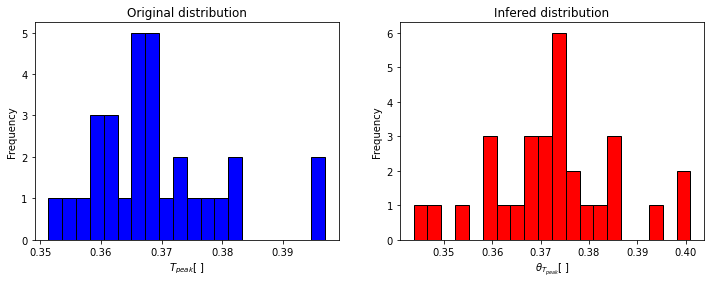

In [ ]:
x = np.arange(0,len(history_list), 1)
means = []
for i in range(len(x)):
     means.append(np.mean(np.array((np.array(history_list[i][9])[:,0]))))
     

data_ref = np.genfromtxt('Data/Data_four_wheel/priors.csv', delimiter=',')
T_peak_ref = data_ref[:,0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(T_peak_ref, bins=20,  color='blue', edgecolor='black')
ax1.set_xlabel(r'$ T_{peak} \rm [\;]$')
ax1.set_ylabel(r'Frequency')
ax1.set_title(r'Original distribution'.format(0))
ax2.hist(means, bins=20,  color='red', edgecolor='black')
ax2.set_xlabel(r'$\theta_{T_{peak}} \rm [\;]$')
ax2.set_ylabel(r'Frequency')
ax2.set_title(r'Infered distribution'.format(0))

Text(0.5, 1.0, 'Infered distribution')

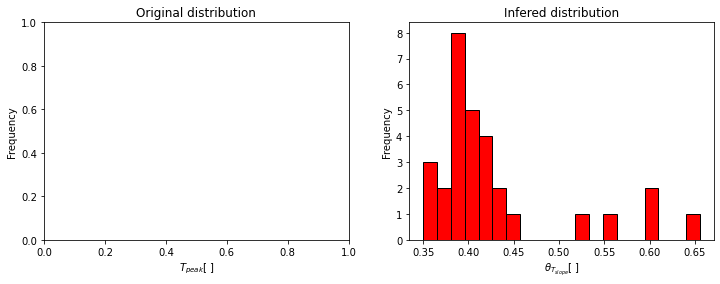

In [ ]:
x = np.arange(0,len(history_list), 1)
means = []
for i in range(len(x)):
     means.append(np.mean(np.array((np.array(history_list[i][9])[:,0]))))
     

data_ref = np.genfromtxt('Data/Data_four_wheel/priors.csv', delimiter=',')
T_slope_ref = data_ref[:,1]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(T_slope_ref, bins=20,  color='blue', edgecolor='black')
ax1.set_xlabel(r'$ T_{slope} \rm [\;]$')
ax1.set_ylabel(r'Frequency')
ax1.set_title(r'Original distribution'.format(0))
ax2.hist(means, bins=20,  color='red', edgecolor='black')
ax2.set_xlabel(r'$\theta_{T_{slope}} \rm [\;]$')
ax2.set_ylabel(r'Frequency')
ax2.set_title(r'Infered distribution'.format(0))

array([0.36750444, 0.37224049, 0.37116748, 0.3782123 , 0.37391622,
       0.38090162, 0.36542665, 0.37059731, 0.37201253, 0.3780591 ])

In [86]:
sc.norm.fit(pso.particle_positions_history[8][:,1])

(0.38574387028260476, 0.00751074523247367)

Text(0.5, 1.0, '$\\mathrm{Iteration}\\ 0$')

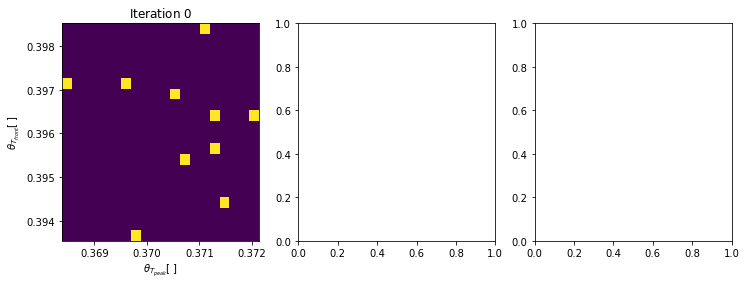

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
# Plot histogram at the start
ax1.hist2d(pso.particle_positions_history[14][:, 0], pso.particle_positions_history[14][:, 1], bins=20, cmap='viridis')
ax1.set_xlabel(r'$ \theta_{T_{peak}} \rm [\;]$')
ax1.set_ylabel(r'$ \theta_{T_{front}} \rm [\;]$')
ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

In [70]:
y_likelihood = np.zeros((30)).reshape(-1,1)

In [71]:
y_likelihood

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])